In [2]:
# Standard Imports

import numpy as np
import pandas as pd

# NLP Imports
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from numpy import nan 
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

# Metrics
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Different sklearn Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb

# Neural Network Models
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

# Graph Imports
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Reading in the data sets:
- Train: The training data set provided by Kaggle
- Test: The test set which is similar to the train set but missing the sentiment column to be solved.
- Sample Submission File: Provided by Kaggle to frame submission file for upload and evaluation.

In [3]:
train = pd.read_csv('./movie_data/train.tsv',sep='\t')
test = pd.read_csv('./movie_data/test.tsv',sep='\t')

sample = pd.read_csv('./movie_data/sampleSubmission.csv')

In [4]:
#train.head()
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


### Default Function that determines number of unique values, nulls, data types, etc.
- Kaggle data sets are generally pretty clean
- No missing values seen, and no issues with data types

In [5]:
def dfcheck(data):

    #result dataframe
    df = pd.DataFrame()
    #list the colums
    df['columns'] = data.columns.tolist()
    #list the datatypes
    df['datatype'] = data.dtypes.tolist()
    # count of observations
    df['count'] = data.count().tolist()
    # count of unique values
    df['unique'] = [len(data[c].unique()) for c in data]
    #list null counts per column
    df['nulls'] = data.isnull().sum().tolist()
    df['%_null'] = df['nulls'] / df['count']
    df = df.drop('count',axis=1)
    #compile list of outliers for numeric columns
    df['outliers'] = [data[c][data[c] > data[c].mean() + (4 * data[c].std())].count() 
                if data[c].dtype == 'int64' 
                or data[c].dtype == 'float64' 
                else None for c in data]
    #returns a summary df
    return df

In [6]:
dfcheck(train)

,columns,datatype,unique,nulls,%_null,outliers
0,PhraseId,int64,156060,0,0.0,0.0
1,SentenceId,int64,8529,0,0.0,0.0
2,Phrase,object,156060,0,0.0,NaN
3,Sentiment,int64,5,0,0.0,0.0


### Following cell takes every categorical numeric value (provided by Kaggle) and assigns their meaning:
- Negative
- Neutral
- Somewhat Negative
- Somewhat Positive
- Positive

In [7]:
Sentiment_words=[]
for row in train.Sentiment:
    if row ==0:
        Sentiment_words.append('negative')
    elif row == 1:
        Sentiment_words.append('somewhat negative')
    elif row == 2:
        Sentiment_words.append('neutral')
    elif row == 3:
        Sentiment_words.append('somewhat positive')
    elif row == 4:
        Sentiment_words.append('positive')
    else:
        Sentiment_words.append('Failed')
train['Sentiment_words'] = Sentiment_words

In [8]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_words
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


### Breakout each category to determine how many of each phrase correponds to sentiment.

In [9]:
sentiment_count = pd.value_counts(train['Sentiment_words'].values)

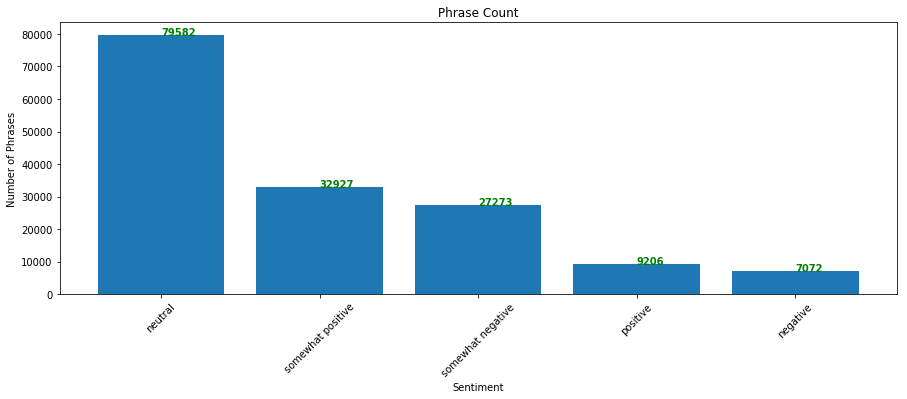

In [15]:
Index = [1,2,3,4,5]
plt.figure(figsize=(15,5))
plt.bar(Index, sentiment_count, color = 'blue')
plt.xticks(Index,['neutral','somewhat positive','somewhat negative','positive','negative'],rotation=45)
plt.ylabel('Number of Phrases')
plt.xlabel('Sentiment')
plt.title('Phrase Count')
plt.bar(Index, sentiment_count)
for a,b in zip(Index, sentiment_count):
    plt.text(a, b, str(b) ,color='green', fontweight='bold')

In [16]:
train['Sentiment_words'].value_counts()

neutral              79582
somewhat positive    32927
somewhat negative    27273
positive              9206
negative              7072
Name: Sentiment_words, dtype: int64

In [17]:
# Baseline accuracy is higher class divided by total.
print('The Baseline Accuracy is', \
      round(train['Sentiment'].value_counts().max() / train['Sentiment'].value_counts().sum(), 2))

The Baseline Accuracy is 0.51


In [18]:
phrases = train['Phrase']

In [19]:
#phrases.to_csv('phrases.csv', index=False)

### The following function will clean the phrases in the Phrase column eliminating "English" stop words and using the WordNet Lemmatizer in NLTK to group together inflections of a word for easier analysis.  With large data sets like the train set, running this function will take several minutes (8-18 depending on which computer I have run the cell)

In [20]:
def review_to_words(org_review): 
    review = org_review
    review = re.sub('[^a-zA-Z]', ' ',review)
    review = review.lower()
    review = review.split()
    lemmatizer = WordNetLemmatizer()
    review = [lemmatizer.lemmatize(w) for w in review if not w in set(stopwords.words('english'))]
    return (' '.join(review))

In [21]:
%%time

corpus= []
for i in range(0, train.shape[0]):
    corpus.append(review_to_words(train['Phrase'][i]))

Wall time: 8min 32s


In [22]:
%%time

corpus_test= []
for i in range(0, test.shape[0]):
    corpus_test.append(review_to_words(test['Phrase'][i]))

Wall time: 3min 5s


### The cleaning function is run on both data sets above, and then we add those clean phrases into a column in train and test dropping the original Phrase column.

In [23]:
train['Clean_Phrase']=corpus
test['Clean_Phrase']=corpus_test

In [24]:
train.drop(['Phrase'],axis=1,inplace=True)
test.drop(['Phrase'],axis=1,inplace=True)
train.head()

,PhraseId,SentenceId,Sentiment,Sentiment_words,Clean_Phrase
0,1,1,1,somewhat negative,series escapade demonstrating adage good goose...
1,2,1,2,neutral,series escapade demonstrating adage good goose
2,3,1,2,neutral,series
3,4,1,2,neutral,
4,5,1,2,neutral,series


In [25]:
#train.to_csv('phrases.csv', index=False)

### Filtering by positive words to determine which words in the phrase are considered positive words and sorting them by top 10 (or whatever we want).  Can do this later for other sentiment values.  More for analysis and later reporting, not so much needed for the model.

In [26]:
positive=train[train['Sentiment_words']==('positive')]

words = ' '.join(positive['Clean_Phrase'])
split_word = " ".join([word for word in words.split()])

positive.head()

,PhraseId,SentenceId,Sentiment,Sentiment_words,Clean_Phrase
63,64,2,4,positive,quiet introspective entertaining independent w...
66,67,2,4,positive,quiet introspective entertaining independent
74,75,2,4,positive,entertaining
77,78,2,4,positive,worth seeking
117,118,4,4,positive,positively thrilling combination ethnography i...


In [27]:
pos=positive['Clean_Phrase']

cvr = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000)

pos_words = cvr.fit_transform(pos)

pos_words = pos_words.toarray()

pos= cvr.get_feature_names()

#Add up all the positive words
dist = np.sum(pos_words, axis=0)


In [28]:
positive_new = pd.DataFrame(dist)

positive_new.columns=['word_count']

positive_new['word'] = pd.Series(pos, index=positive_new.index)

positive_new.head()

,word_count,word
0,20,ability
1,32,able
2,9,absolute
3,24,absolutely
4,18,absorbing


In [29]:
positive_new1=positive_new[['word','word_count']]

sorted_positive_new1 = positive_new1.sort_values(['word_count'], ascending=False)

sorted_positive_new1.head(10)

,word,word_count
652,film,1104
1149,movie,757
1223,one,517
1280,performance,472
161,best,394
715,funny,347
760,good,339
1933,well,317
1672,story,280
1990,year,275


### Getting data ready for model

In [30]:
cv = CountVectorizer(stop_words='english', strip_accents='ascii', max_features= 2000)
X = cv.fit_transform(corpus).toarray()  #  was x__train
test_X = cv.fit_transform(corpus_test).toarray() # was x__test
y = train.iloc[:, 2].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state = 0)

### Multinomial Naive Bayes Model

In [32]:
%%time

pipeline1 = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
]) 

pipeline1.fit(X_train, y_train)


Wall time: 2.92 s


In [33]:
y_pred = pipeline1.predict(X_test)
y_real_pred = pipeline1.predict(test_X)

In [34]:
print(classification_report(y_test, 
                    y_pred,
                    labels=pipeline1.classes_,
                    target_names = ['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive']))


print("Accuracy:" + str(round(pipeline1.score(X_test, y_test), 3)))

                   precision    recall  f1-score   support

         Negative       0.66      0.03      0.05      2931
Somewhat Negative       0.49      0.13      0.21     10824
          Neutral       0.58      0.94      0.72     31864
Somewhat Positive       0.52      0.27      0.35     13068
         Positive       0.66      0.05      0.10      3737

      avg / total       0.56      0.57      0.48     62424

Accuracy:0.566


In [35]:
confusion_matrix(y_test, 
                 y_pred,
                 labels=[0, 1, 2, 3, 4]
            )

array([[   82,   773,  2001,    75,     0],
       [   30,  1457,  8998,   337,     2],
       [   10,   590, 30094,  1154,    16],
       [    2,   113,  9387,  3484,    82],
       [    0,    15,  1829,  1698,   195]], dtype=int64)

### Bernoulli Naive Bayes Model

In [36]:
%%time

pipeline2 = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB())
]) 

pipeline2.fit(X_train, y_train)

Wall time: 3.05 s


In [37]:
y_pred = pipeline2.predict(X_test)
y_real_pred = pipeline2.predict(test_X)

In [38]:
print(classification_report(y_test, 
                    y_pred,
                    labels=pipeline2.classes_,
                    target_names = ['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive']))


print("Accuracy:" + str(round(pipeline2.score(X_test, y_test), 3)))

                   precision    recall  f1-score   support

         Negative       0.39      0.21      0.28      2931
Somewhat Negative       0.46      0.26      0.33     10824
          Neutral       0.64      0.87      0.74     31864
Somewhat Positive       0.50      0.35      0.41     13068
         Positive       0.46      0.24      0.32      3737

      avg / total       0.55      0.59      0.55     62424

Accuracy:0.587


In [39]:
confusion_matrix(y_test, 
                 y_pred,
                 labels=[0, 1, 2, 3, 4]
            )

array([[  627,   946,  1153,   175,    30],
       [  586,  2818,  6491,   818,   111],
       [  244,  1685, 27682,  2045,   208],
       [  127,   586,  7010,  4631,   714],
       [   37,   106,  1054,  1642,   898]], dtype=int64)

### Trying out Random Forest Classifier with features run on a different computer as optimal.

In [40]:
%%time

pipeline3 = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators = 11, min_samples_leaf = 1, max_features = 'log2',
                                  criterion = 'entropy', bootstrap = False))
]) 

pipeline3.fit(X_train, y_train)

Wall time: 1min 56s


In [41]:
y_pred = pipeline3.predict(X_test)
y_real_pred = pipeline3.predict(test_X)

In [42]:
print(classification_report(y_test, 
                    y_pred,
                    labels=pipeline3.classes_,
                    target_names = ['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive']))


print("Accuracy:" + str(round(pipeline3.score(X_test, y_test), 3)))

                   precision    recall  f1-score   support

         Negative       0.43      0.36      0.39      2931
Somewhat Negative       0.49      0.38      0.43     10824
          Neutral       0.68      0.82      0.74     31864
Somewhat Positive       0.54      0.43      0.48     13068
         Positive       0.50      0.32      0.39      3737

      avg / total       0.59      0.61      0.60     62424

Accuracy:0.613


In [43]:
confusion_matrix(y_test, 
                 y_pred,
                 labels=[0, 1, 2, 3, 4]
            )

array([[ 1048,  1064,   733,    75,    11],
       [  994,  4160,  5225,   408,    37],
       [  320,  2686, 26209,  2474,   175],
       [   59,   442,  5959,  5614,   994],
       [    7,    56,   661,  1801,  1212]], dtype=int64)

### Trying out Logistic Regression GridSearch which finishes in a reasonable amount of time

In [44]:
%%time

pipeline4 = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(penalty = 'l1', C = 10))
]) 

pipeline4.fit(X_train, y_train)

Wall time: 5.11 s


In [45]:
y_pred = pipeline4.predict(X_test)
y_real_pred = pipeline4.predict(test_X)

In [46]:
print(classification_report(y_test, 
                    y_pred,
                    labels=pipeline4.classes_,
                    target_names = ['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive']))


print("Accuracy:" + str(round(pipeline4.score(X_test, y_test), 3)))

                   precision    recall  f1-score   support

         Negative       0.49      0.17      0.25      2931
Somewhat Negative       0.47      0.27      0.34     10824
          Neutral       0.64      0.87      0.74     31864
Somewhat Positive       0.51      0.41      0.45     13068
         Positive       0.54      0.24      0.33      3737

      avg / total       0.57      0.60      0.56     62424

Accuracy:0.6


In [47]:
confusion_matrix(y_test, 
                 y_pred,
                 labels=[0, 1, 2, 3, 4]
            )

array([[  495,  1107,  1117,   194,    18],
       [  367,  2876,  6696,   845,    40],
       [  108,  1534, 27830,  2267,   125],
       [   28,   465,  6635,  5353,   587],
       [    4,    81,   903,  1849,   900]], dtype=int64)

### XGB Boost

In [ ]:
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(test_X, label=test_Y)

### Trying out a Neural Network

In [48]:
y = to_categorical(train.iloc[:, 2].values)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state = 0)

In [50]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

C:\Users\aggie\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [54]:
%%time

model = Sequential()

# 4 features
model.add(Dense(4, input_dim = X_train.shape[1], activation = 'relu'))


# for multi-class need same # of neurons for classes so 3 in this example and activation of softmax
model.add(Dense(5, activation = 'softmax'))
model.add(Dropout(0.8))
model.add(Dense(10, activation = 'softmax'))
model.add(Dropout(0.8))
model.add(Dense(5, activation = 'softmax'))
model.add(Dropout(0.8))
model.add(Dense(5, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(X_train_sc, y_train, validation_data = (X_test_sc, y_test), epochs = 30, verbose = 1)

Train on 93636 samples, validate on 62424 samples
Epoch 1/30
93636/93636 [==============================] - 14s 153us/step - loss: 1.3310 - acc: 0.4969 - val_loss: 1.2869 - val_acc: 0.5104
Epoch 2/30
93636/93636 [==============================] - 13s 138us/step - loss: 1.2834 - acc: 0.5096 - val_loss: 1.2866 - val_acc: 0.5104
Epoch 3/30
93636/93636 [==============================] - 13s 141us/step - loss: 1.2823 - acc: 0.5096 - val_loss: 1.2865 - val_acc: 0.5104
Epoch 4/30
93636/93636 [==============================] - 13s 141us/step - loss: 1.2818 - acc: 0.5096 - val_loss: 1.2864 - val_acc: 0.5104
Epoch 5/30
93636/93636 [==============================] - 13s 139us/step - loss: 1.2818 - acc: 0.5096 - val_loss: 1.2865 - val_acc: 0.5104
Epoch 6/30
93636/93636 [==============================] - 13s 140us/step - loss: 1.2815 - acc: 0.5096 - val_loss: 1.2857 - val_acc: 0.5104
Epoch 7/30
93636/93636 [==============================] - 13s 143us/step - loss: 1.2814 - acc: 0.5096 - val_loss: 1.

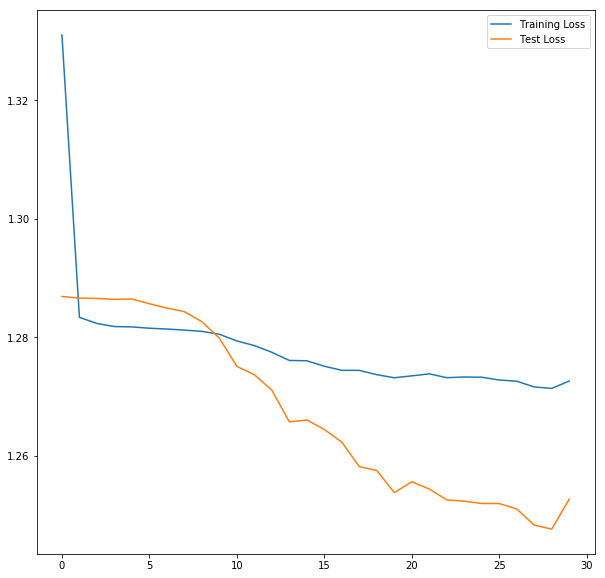

In [55]:
plt.figure(figsize = (10,10)) # set how large the chart is
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.legend()

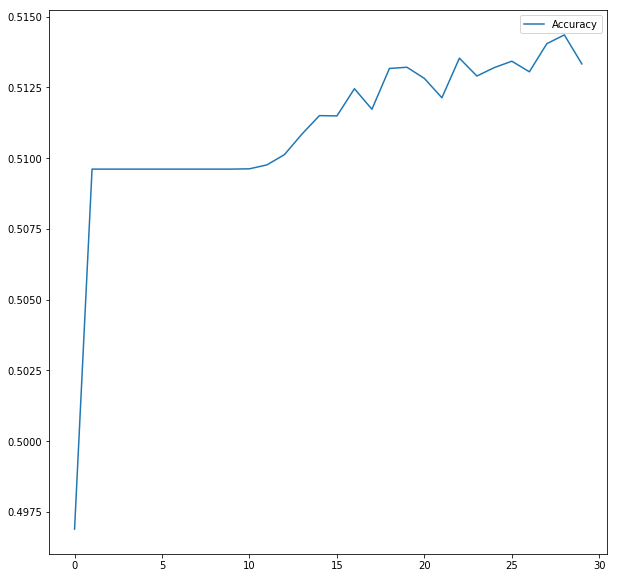

In [56]:
plt.figure(figsize = (10,10)) # set how large the chart is
plt.plot(history.history['acc'], label = 'Accuracy')
#plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.legend()

In [44]:
y_pred = model.predict(X_test)
y_real_pred = model.predict(test_X)

In [45]:
print(classification_report(y_test, 
                    y_pred))

ValueError: Mix type of y not allowed, got types {'continuous-multioutput', 'multilabel-indicator'}

In [46]:
y_pred

array([[0.06371108, 0.24322541, 0.4099498 , 0.25857824, 0.02453541],
       [0.06758557, 0.25547823, 0.41677445, 0.23856355, 0.02159821],
       [0.06845319, 0.25825047, 0.41834942, 0.23398857, 0.02095838],
       ...,
       [0.06606555, 0.25065073, 0.4140655 , 0.24648482, 0.02273331],
       [0.06758557, 0.25547823, 0.41677445, 0.23856355, 0.02159821],
       [0.05829389, 0.22628091, 0.40067583, 0.28582224, 0.02892706]],
      dtype=float32)

In [48]:
y_test

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [31]:
print(classification_report(y_test, 
                    y_pred,
                    labels=model.classes_,
                    target_names = ['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive']))


print("Accuracy:" + str(round(model.score(X_test, y_test), 3)))

AttributeError: 'Sequential' object has no attribute 'classes_'

In [ ]:
confusion_matrix(y_test, 
                 y_pred,
                 labels=[0, 1, 2, 3, 4]
            )

### Trash???

In [ ]:
params = {
    'n_estimators' : [1, 3, 5, 7, 9, 11],
    'min_samples_leaf' : [1, 3, 5, 7, 9],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'log2'],
    'bootstrap': [True, False]
}

GridSearchCV(
    RandomForestClassifier(),
    params
)

In [ ]:
random_forest = GridSearchCV(
    RandomForestClassifier(),
    params
).fit(X_train, y_train)

In [ ]:
random_forest.score(X_test, y_test)

In [ ]:
knn =GridSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors':[1, 3, 5, 7, 9],
        'weights':['uniform', 'distance'],
        'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']

    }
)

In [ ]:
%%time

knn.fit(X_train, y_train)

In [ ]:
knn.score(X_test, y_test)

In [ ]:
#predictions = clf1.predict(test_X)  # for submission to Kaggle

#test['Sentiment'] = predictions

# test[['PhraseId', 'Sentiment']].to_csv('submission.csv', index=False)